In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re
from matplotlib import pyplot as plt
import matplotlib
import fastText
import html
import string
import nltk
from multiprocessing import Process
import multiprocessing
import time
import sys
from importlib import reload
import redis
# from urllib import request
from urllib.parse import urlparse
import requests as req
# from lxml import html
import logging
# from scrapy.http import Request
import requests
import json
import requests
from scrapy.http import TextResponse
from bs4 import BeautifulSoup
import re
from collections import Counter
from sklearn.metrics import precision_recall_curve
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pandas as pd
import math
import mpld3
import pickle

mpld3.enable_notebook()
%matplotlib inline

In [3]:
import utils
utils = reload(utils)

In [4]:
df_comparisons = pd.read_csv('df_comparisons_unsup_lemma.csv', index_col=0)

In [5]:
df_news = pd.read_csv('df_news_unsup_lemma.csv', parse_dates=['Datetime', 'Date'])

In [6]:
fields = ['title', 'spot','text']

In [7]:
for field in fields:
    df_news[field+'_pp_str'].fillna('', inplace=True)
    df_news[field+'_pp'] = df_news[field+'_pp_str'].apply(lambda x: x.split())

In [8]:
for index, row in df_comparisons.iterrows():
    
    row_1 = df_news.iloc[int(row.ind0)]
    row_2 = df_news.iloc[int(row.ind1)]
    
    # Datetime difference features
    dt_1 = row_1.Datetime
    dt_2 = row_2.Datetime
    d_1 = row_1.Date
    d_2 = row_2.Date
    diff = dt_1 - dt_2
    diff_days = abs(diff.days)
    diff_hours = abs(diff.total_seconds() / 3600)
    df_comparisons.loc[index, 'diff_days'] = diff_days
    df_comparisons.loc[index, 'diff_hours'] = diff_hours
    
    # Length features
    for field in ['text','title','spot']:
        
        len1 = len(row_1[field+'_pp'])
        len2 = len(row_2[field+'_pp'])
        
        df_comparisons.loc[index, 'len_'+field+'_min'] = min(len1, len2)
        df_comparisons.loc[index, 'len_'+field+'_max'] = max(len1, len2)
        df_comparisons.loc[index, 'len_'+field+'_diff'] = abs(len1 - len2)
        
        if max(len1, len2) == 0:
            diff_perc = -1
            max_o_min = -1
        else:
            diff_perc = abs(len1 - len2) / max(len1, len2)
            
            if min(len1, len2) == 0:
                max_o_min = 100
            else:
                max_o_min = max(len1, len2) / min(len1, len2)
                
        df_comparisons.loc[index, 'len_'+field+'_diff_perc'] = diff_perc
        df_comparisons.loc[index, 'len_'+field+'_max_o_min'] = max_o_min

In [9]:
df_comparisons_bu = df_comparisons.copy()

In [10]:
df_comparisons = df_comparisons_bu.copy()

In [11]:
for field in fields:
    
    colnow = 'len_' + field + '_diff_perc'
    indsnow = df_comparisons[colnow] == -1
    df_comparisons.loc[indsnow,colnow] = 0
    
    colnow = 'len_' + field + '_max_o_min'
    indsnow = df_comparisons[colnow] == -1
    df_comparisons.loc[indsnow,colnow] = 1
    
    indsnow = df_comparisons[colnow] == 100
    maxnow = df_comparisons[~indsnow][colnow].max()
    df_comparisons.loc[indsnow,colnow] = maxnow

In [12]:
df_comparisons.diff_days.fillna(df_comparisons.diff_days.mean(), inplace=True)
df_comparisons.diff_hours.fillna(df_comparisons.diff_hours.mean(), inplace=True)

In [13]:
methods = ['ju', 'js','jc', 'ft', 'wv']
methods_cross = [met + '_' + field for met in methods for field in fields]
methods_cross_norm = [met+'_norm' for met in methods_cross]

features = ['min', 'max', 'diff', 'diff_perc', 'max_o_min']
columns_sup = ['len_' + field + '_' + feat for field in fields for feat in features] + ['diff_days', 'diff_hours']

columns_all = methods_cross_norm + columns_sup + ['comb'] 

In [14]:
def print_prec_recall(colnames, return_res=False, dfnow=None):
    
    if dfnow is None:
        dfnow = df_comparisons
        
    if not isinstance(colnames, list):
        colnames = [colnames]
    
    table = []
    res = {}
    for colname in colnames:
    
        predictions = dfnow[colname]
        labels = dfnow['label']

        acc = float((predictions == labels).sum() / len(predictions))

        true_positive = float(np.logical_and(predictions==1, labels==1).sum())
        true_negative = float(np.logical_and(predictions==0, labels==0).sum())
        false_positive = float(np.logical_and(predictions==1, labels==0).sum())
        false_negative = float(np.logical_and(predictions==0, labels==1).sum())

        if predictions.sum() == 0 or predictions.sum() == predictions.shape[0]:
            print("Warning! number of positive predictions: %i" % predictions.sum())
            precision = 0 
            recall = 0
            f1 = 0
        else:
            precision = float(true_positive / (true_positive + false_positive))
            recall = float(true_positive / (true_positive + false_negative))
            f1 = 2*(recall * precision) / (recall + precision)
    
        table.append([colname, acc, f1, precision, recall, true_positive, true_negative, false_positive, false_negative])
        
        res[colname] = dict(
            acc = acc,
            f1 = f1,
            precision = precision,
            recall = recall,
            true_positive = true_positive,
            true_negative = true_negative,
            false_positive = false_positive,
            false_negative = false_negative)

    print(tabulate(table, headers=['METHOD', 'ACC', 'F1', 'PREC', 'RECALL', 'TP', 'TN', 'FP', 'FN'], tablefmt="fancy_grid"))
    
    if return_res:
        return res

__Normalize all features to [0,1]__

In [15]:
norm_params = dict(
    ju_title_norm = [-1, 6],
    ju_spot_norm = [-0.5, 5],
    ju_text_norm = [-0.5, 4.9],
    js_title_norm = [-4, 2.5],
    js_spot_norm = [-4.5, 3],
    js_text_norm = [-1.3, 3.2],
    jc_title_norm = [-0.6, 6],
    jc_spot_norm = [-0.6, 5],
    jc_text_norm = [-0.5, 4.9],
    ft_title_norm = [-1.5, 0.7],
    ft_spot_norm = [-2, 0.6],
    ft_text_norm = [-4, 0.8],
    wv_title_norm = [-4, 1.7],
    wv_spot_norm = [-4, 1.1],
    wv_text_norm = [-4, 0.8],
    len_title_min = [1, 12],
    len_title_max = [1, 19],
    len_title_diff = [0, 18],
    len_title_diff_perc = [0, 1],
    len_title_max_o_min = [1, 14],
    len_spot_min = [0, 80],
    len_spot_max = [0, 100],
    len_spot_diff = [0, 100],
    len_spot_diff_perc = [0, 1],
    len_spot_max_o_min = [1, 100],
    len_text_min = [0, 1000],
    len_text_max = [30, 2500],
    len_text_diff = [0, 2500],
    len_text_diff_perc = [0, 1],
    len_text_max_o_min = [1, 100],
    comb = [-2.5, 3.5],
    comb02 = [-0.7, 5],
    comb03 = [-4, 1],
    diff_days = [0,40],
    diff_hours=[0, 1200]
)

In [16]:
len(columns_all)

33

In [17]:
for colname in columns_all:
    minnow, maxnow = norm_params[colname]
    df_comparisons[colname+'_snorm'] = (df_comparisons[colname] - minnow ) / maxnow

In [18]:
columns_all_snorm = [colname+'_snorm' for colname in columns_all]

__Split validations__

In [19]:
n_val_splits = 10

dfs_val_comparisons = utils.split_val_parts(df_comparisons, n_val_splits)

0
(1712, 91)
label
0.0    1530
1.0     182
Name: label, dtype: int64

1
(1672, 91)
label
0.0    1490
1.0     182
Name: label, dtype: int64

2
(1668, 91)
label
0.0    1508
1.0     160
Name: label, dtype: int64

3
(1711, 91)
label
0.0    1509
1.0     202
Name: label, dtype: int64

4
(1636, 91)
label
0.0    1456
1.0     180
Name: label, dtype: int64

5
(1720, 91)
label
0.0    1540
1.0     180
Name: label, dtype: int64

6
(1739, 91)
label
0.0    1559
1.0     180
Name: label, dtype: int64

7
(1750, 91)
label
0.0    1533
1.0     217
Name: label, dtype: int64

8
(1626, 91)
label
0.0    1447
1.0     179
Name: label, dtype: int64

9
(1624, 91)
label
0.0    1428
1.0     196
Name: label, dtype: int64



__Decision Tree__

In [20]:
colname = 'dt'
classifier_func = lambda: DecisionTreeClassifier(max_depth=None, criterion='entropy', min_samples_leaf=10)
trees, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

print_prec_recall('dt')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ dt       │ 0.996856 │ 0.985718 │ 0.987048 │ 0.984392 │ 1829 │ 14976 │   24 │   29 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__Random Forest__

In [20]:
colname = 'rf'
classifier_func = lambda: RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
rfs, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

In [21]:
print_prec_recall('rf')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf       │ 0.998042 │ 0.991117 │ 0.991384 │  0.99085 │ 1841 │ 14984 │   16 │   17 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [22]:
print_prec_recall('rf')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf       │ 0.998102 │ 0.991398 │ 0.990333 │ 0.992465 │ 1844 │ 14982 │   18 │   14 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [57]:
print_prec_recall('rf')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf       │ 0.997627 │ 0.989236 │ 0.989236 │ 0.989236 │ 1838 │ 14980 │   20 │   20 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__MLP__

In [22]:
colname = 'mlp'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

Iteration 1, loss = 0.15315434
Iteration 2, loss = 0.02994426
Iteration 3, loss = 0.01893773
Iteration 4, loss = 0.01423254
Iteration 5, loss = 0.01168458
Iteration 6, loss = 0.01035314
Iteration 7, loss = 0.00944107
Iteration 8, loss = 0.00867658
Iteration 9, loss = 0.00803170
Iteration 10, loss = 0.00798174
Iteration 11, loss = 0.00729776
Iteration 12, loss = 0.00699552
Iteration 13, loss = 0.00639632
Iteration 14, loss = 0.00638440
Iteration 15, loss = 0.00640998
Iteration 16, loss = 0.00596448
Iteration 17, loss = 0.00596931
Iteration 18, loss = 0.00624012
Iteration 19, loss = 0.00541072
Iteration 20, loss = 0.00555461
Iteration 21, loss = 0.00536593
Iteration 22, loss = 0.00498404
Iteration 23, loss = 0.00480460
Iteration 24, loss = 0.00474396
Iteration 25, loss = 0.00509466
Iteration 26, loss = 0.00464945
Iteration 27, loss = 0.00482405
Iteration 28, loss = 0.00512651
Iteration 29, loss = 0.00486291
Iteration 30, loss = 0.00441044
Iteration 31, loss = 0.00462282
Iteration 32, los

Iteration 6, loss = 0.01025525
Iteration 7, loss = 0.00918694
Iteration 8, loss = 0.00853028
Iteration 9, loss = 0.00788229
Iteration 10, loss = 0.00739960
Iteration 11, loss = 0.00740781
Iteration 12, loss = 0.00678629
Iteration 13, loss = 0.00665647
Iteration 14, loss = 0.00753746
Iteration 15, loss = 0.00639939
Iteration 16, loss = 0.00588923
Iteration 17, loss = 0.00556257
Iteration 18, loss = 0.00554997
Iteration 19, loss = 0.00554680
Iteration 20, loss = 0.00515911
Iteration 21, loss = 0.00548025
Iteration 22, loss = 0.00538930
Iteration 23, loss = 0.00521931
Iteration 24, loss = 0.00481510
Iteration 25, loss = 0.00546225
Iteration 26, loss = 0.00472537
Iteration 27, loss = 0.00457500
Iteration 28, loss = 0.00453942
Iteration 29, loss = 0.00453671
Iteration 30, loss = 0.00445322
Iteration 31, loss = 0.00445202
Iteration 32, loss = 0.00414911
Iteration 33, loss = 0.00419597
Iteration 34, loss = 0.00415082
Iteration 35, loss = 0.00442588
Iteration 36, loss = 0.00394748
Iteration 37

Iteration 7, loss = 0.00849561
Iteration 8, loss = 0.00760724
Iteration 9, loss = 0.00726822
Iteration 10, loss = 0.00667283
Iteration 11, loss = 0.00636577
Iteration 12, loss = 0.00604458
Iteration 13, loss = 0.00525928
Iteration 14, loss = 0.00554091
Iteration 15, loss = 0.00514938
Iteration 16, loss = 0.00502807
Iteration 17, loss = 0.00490618
Iteration 18, loss = 0.00475220
Iteration 19, loss = 0.00467059
Iteration 20, loss = 0.00439073
Iteration 21, loss = 0.00443745
Iteration 22, loss = 0.00413698
Iteration 23, loss = 0.00437586
Iteration 24, loss = 0.00417079
Iteration 25, loss = 0.00408469
Iteration 26, loss = 0.00377438
Iteration 27, loss = 0.00392048
Iteration 28, loss = 0.00415285
Iteration 29, loss = 0.00405873
Iteration 30, loss = 0.00372013
Iteration 31, loss = 0.00429047
Iteration 32, loss = 0.00340911
Iteration 33, loss = 0.00346169
Iteration 34, loss = 0.00339865
Iteration 35, loss = 0.00351796
Iteration 36, loss = 0.00387455
Iteration 37, loss = 0.00340949
Iteration 3

Iteration 65, loss = 0.00231124
Iteration 66, loss = 0.00229718
Iteration 67, loss = 0.00236349
Iteration 68, loss = 0.00234239
Iteration 69, loss = 0.00264906
Iteration 70, loss = 0.00200932
Iteration 71, loss = 0.00227127
Iteration 72, loss = 0.00184023
Iteration 73, loss = 0.00230371
Iteration 74, loss = 0.00224404
Iteration 75, loss = 0.00243868
Iteration 76, loss = 0.00179501
Iteration 77, loss = 0.00183393
Iteration 78, loss = 0.00216342
Iteration 79, loss = 0.00165819
Iteration 80, loss = 0.00199391
Iteration 81, loss = 0.00211213
Iteration 82, loss = 0.00162282
Iteration 83, loss = 0.00141993
Iteration 84, loss = 0.00222754
Iteration 85, loss = 0.00190247
Iteration 86, loss = 0.00209758
Iteration 87, loss = 0.00161042
Iteration 88, loss = 0.00130330
Iteration 89, loss = 0.00146622
Iteration 90, loss = 0.00137914
Iteration 91, loss = 0.00142910
Iteration 92, loss = 0.00156987
Iteration 93, loss = 0.00164642
Iteration 94, loss = 0.00131916
Iteration 95, loss = 0.00133144
Iteratio

In [23]:
print_prec_recall('mlp')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.998339 │ 0.992457 │ 0.993528 │ 0.991389 │ 1842 │ 14988 │   12 │   16 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [24]:
colname = 'mlp'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

Iteration 1, loss = 0.16792233
Iteration 2, loss = 0.02912070
Iteration 3, loss = 0.01703608
Iteration 4, loss = 0.01238783
Iteration 5, loss = 0.01020570
Iteration 6, loss = 0.00900594
Iteration 7, loss = 0.00801819
Iteration 8, loss = 0.00732486
Iteration 9, loss = 0.00666726
Iteration 10, loss = 0.00634718
Iteration 11, loss = 0.00615764
Iteration 12, loss = 0.00599298
Iteration 13, loss = 0.00545452
Iteration 14, loss = 0.00573427
Iteration 15, loss = 0.00523560
Iteration 16, loss = 0.00495779
Iteration 17, loss = 0.00505231
Iteration 18, loss = 0.00452466
Iteration 19, loss = 0.00449204
Iteration 20, loss = 0.00471504
Iteration 21, loss = 0.00444536
Iteration 22, loss = 0.00457371
Iteration 23, loss = 0.00395170
Iteration 24, loss = 0.00392321
Iteration 25, loss = 0.00466370
Iteration 26, loss = 0.00453988
Iteration 27, loss = 0.00397234
Iteration 28, loss = 0.00376185
Iteration 29, loss = 0.00350091
Iteration 30, loss = 0.00399674
Iteration 31, loss = 0.00379844
Iteration 32, los

In [58]:
colname = 'mlp'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

Iteration 1, loss = 0.18271248
Iteration 2, loss = 0.03412051
Iteration 3, loss = 0.02083362
Iteration 4, loss = 0.01593665
Iteration 5, loss = 0.01301535
Iteration 6, loss = 0.01143980
Iteration 7, loss = 0.01046403
Iteration 8, loss = 0.00980589
Iteration 9, loss = 0.00875878
Iteration 10, loss = 0.00839338
Iteration 11, loss = 0.00806896
Iteration 12, loss = 0.00806123
Iteration 13, loss = 0.00781654
Iteration 14, loss = 0.00734272
Iteration 15, loss = 0.00704730
Iteration 16, loss = 0.00682917
Iteration 17, loss = 0.00688365
Iteration 18, loss = 0.00653356
Iteration 19, loss = 0.00659759
Iteration 20, loss = 0.00637921
Iteration 21, loss = 0.00634581
Iteration 22, loss = 0.00626879
Iteration 23, loss = 0.00601960
Iteration 24, loss = 0.00596349
Iteration 25, loss = 0.00617894
Iteration 26, loss = 0.00571825
Iteration 27, loss = 0.00617680
Iteration 28, loss = 0.00532128
Iteration 29, loss = 0.00573483
Iteration 30, loss = 0.00535746
Iteration 31, loss = 0.00549826
Iteration 32, los

In [59]:
print_prec_recall('mlp')

╒══════════╤═════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.99822 │ 0.991927 │ 0.991927 │ 0.991927 │ 1843 │ 14985 │   15 │   15 │
╘══════════╧═════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [117]:
colname = 'mlp'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

Iteration 1, loss = 0.28066141
Iteration 2, loss = 0.06457892
Iteration 3, loss = 0.03254234
Iteration 4, loss = 0.02133416
Iteration 5, loss = 0.01642850
Iteration 6, loss = 0.01375831
Iteration 7, loss = 0.01249466
Iteration 8, loss = 0.01141594
Iteration 9, loss = 0.01071990
Iteration 10, loss = 0.01043972
Iteration 11, loss = 0.00991410
Iteration 12, loss = 0.00967410
Iteration 13, loss = 0.00996251
Iteration 14, loss = 0.00960363
Iteration 15, loss = 0.00888817
Iteration 16, loss = 0.00889678
Iteration 17, loss = 0.00863993
Iteration 18, loss = 0.00887777
Iteration 19, loss = 0.00863747
Iteration 20, loss = 0.00927467
Iteration 21, loss = 0.00888679
Iteration 22, loss = 0.00852221
Iteration 23, loss = 0.00854013
Iteration 24, loss = 0.00810281
Iteration 25, loss = 0.00864055
Iteration 26, loss = 0.00820343
Iteration 27, loss = 0.00828366
Iteration 28, loss = 0.00768176
Iteration 29, loss = 0.00833697
Iteration 30, loss = 0.00859424
Iteration 31, loss = 0.00752017
Iteration 32, los

In [118]:
print_prec_recall('mlp')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.997212 │ 0.987362 │ 0.986566 │ 0.988159 │ 1836 │ 14975 │   25 │   22 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__SVM__

Grid search for SVM on one split

In [109]:
split_inds = [ii for ii in range(n_val_splits)]
split_inds.remove(0)
df_train_now = pd.concat([dfs_val_comparisons[ii] for ii in split_inds], axis=0).copy()
df_test_now = dfs_val_comparisons[0].copy()

Xtrain = df_train_now[columns_all_snorm].values
ytrain = df_train_now['label'].values
Xtest = df_test_now[columns_all_snorm].values
ytest = df_test_now['label'].values

In [110]:
gs = [1e-7, 1e-5, 1e-3, 1e-1, 1, 10]
cs = [1, 10, 100, 1000, 10000, 100000]

# df_svm_crossval = df_comparisons.copy()

n_gs = len(gs)
n_cs = len(cs)

cv_precs = np.zeros((n_gs, n_cs))
cv_recalls = np.zeros((n_gs, n_cs))
cv_f1s = np.zeros((n_gs, n_cs))

for ind_g in range(n_gs):
    gnow = float(gs[ind_g])
    for ind_c in range(n_cs):
        cnow = cs[ind_c]
        
        colname = 'svm_g_' + str(ind_g) + '_c_' + str(ind_c)
        classifier_func = lambda: SVC(C=cnow, kernel='rbf', gamma=gnow)
        
        model = classifier_func()
        model = model.fit(Xtrain, ytrain)
        
        yhat = model.predict(Xtest)
        df_test_now.loc[df_test_now.index, colname] = yhat
        print('c=%f, g=%e' % (cnow, gnow))
        resnow = print_prec_recall(colname, return_res=True, dfnow=df_test_now)
        
        cv_precs[ind_g, ind_c] = resnow[colname]['precision']
        cv_recalls[ind_g, ind_c] = resnow[colname]['recall']
        cv_f1s[ind_g, ind_c] = resnow[colname]['f1']

c=1.000000, g=1.000000e-07
Warning! number of positive predictions: 0
╒═════════════╤══════════╤══════╤════════╤══════════╤══════╤══════╤══════╤══════╕
│ METHOD      │      ACC │   F1 │   PREC │   RECALL │   TP │   TN │   FP │   FN │
╞═════════════╪══════════╪══════╪════════╪══════════╪══════╪══════╪══════╪══════╡
│ svm_g_0_c_0 │ 0.886053 │    0 │      0 │        0 │    0 │ 1493 │    0 │  192 │
╘═════════════╧══════════╧══════╧════════╧══════════╧══════╧══════╧══════╧══════╛
c=10.000000, g=1.000000e-07
Warning! number of positive predictions: 0
╒═════════════╤══════════╤══════╤════════╤══════════╤══════╤══════╤══════╤══════╕
│ METHOD      │      ACC │   F1 │   PREC │   RECALL │   TP │   TN │   FP │   FN │
╞═════════════╪══════════╪══════╪════════╪══════════╪══════╪══════╪══════╪══════╡
│ svm_g_0_c_1 │ 0.886053 │    0 │      0 │        0 │    0 │ 1493 │    0 │  192 │
╘═════════════╧══════════╧══════╧════════╧══════════╧══════╧══════╧══════╧══════╛
c=100.000000, g=1.000000e-07
Warning! n

In [111]:
print(cv_f1s)

[[0.         0.         0.         0.87790698 0.95675676 0.984375  ]
 [0.         0.87790698 0.95675676 0.984375   0.98963731 0.98963731]
 [0.97066667 0.98701299 0.98701299 0.98445596 0.98445596 0.984375  ]
 [0.98701299 0.98701299 0.984375   0.984375   0.97905759 0.97905759]
 [0.98701299 0.98701299 0.98701299 0.98701299 0.98701299 0.98701299]
 [0.62857143 0.70707071 0.70707071 0.70707071 0.70707071 0.70707071]]


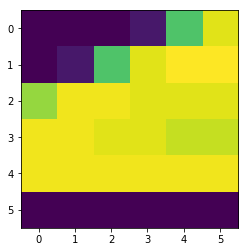

In [114]:
fig, ax1 = plt.subplots(1,1)
tmp = cv_f1s.copy()
tmp[0,:3] = 0.87
tmp[1,0] = 0.87
tmp[-1,:] = 0.87
ax1.imshow(tmp);
# ax1.set_xticklabels(cs)

Train svm

In [24]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤═════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.99822 │ 0.991914 │ 0.993521 │ 0.990312 │ 1840 │ 14988 │   12 │   18 │
╘══════════╧═════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [23]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤═════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.99822 │ 0.991922 │ 0.992457 │ 0.991389 │ 1842 │ 14986 │   14 │   16 │
╘══════════╧═════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [61]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.997983 │ 0.990845 │ 0.991379 │ 0.990312 │ 1840 │ 14984 │   16 │   18 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [96]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.997449 │ 0.988438 │ 0.987641 │ 0.989236 │ 1838 │ 14977 │   23 │   20 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [115]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.997627 │ 0.989218 │ 0.990821 │ 0.987621 │ 1835 │ 14983 │   17 │   23 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__Majority Voting__

In [25]:
df_comparisons['mv'] =  df_comparisons[['mlp','rf','svm']].mode(axis=1)
print_prec_recall('mv')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv       │ 0.998458 │ 0.992996 │ 0.994067 │ 0.991927 │ 1843 │ 14989 │   11 │   15 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [62]:
df_comparisons['mv'] =  df_comparisons[['mlp','rf','svm']].mode(axis=1)
print_prec_recall('mv')

╒══════════╤═════════╤═════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │      F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪═════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv       │ 0.99828 │ 0.99219 │ 0.992992 │ 0.991389 │ 1842 │ 14987 │   13 │   16 │
╘══════════╧═════════╧═════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [99]:
df_comparisons['mv'] =  df_comparisons[['mlp','rf','svm']].mode(axis=1)
print_prec_recall('mv')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv       │ 0.997924 │ 0.990584 │ 0.990317 │  0.99085 │ 1841 │ 14982 │   18 │   17 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__Score averaging combination__

In [63]:
thr_comb = -0.0363691467748684
df_comparisons['comb_class'] = df_comparisons['comb'] >= thr_comb
print_prec_recall('comb_class')

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996322 │ 0.983315 │ 0.983315 │ 0.983315 │ 1827 │ 14969 │   31 │   31 │
╘════════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [100]:
thr_comb = -0.0675493
df_comparisons['comb_class'] = df_comparisons['comb'] >= thr_comb
print_prec_recall('comb_class')

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.995729 │ 0.980624 │ 0.980624 │ 0.980624 │ 1822 │ 14964 │   36 │   36 │
╘════════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [121]:
thr_comb = -0.0200133
df_comparisons['comb_class'] = df_comparisons['comb'] >= thr_comb
print_prec_recall('comb_class')

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996204 │ 0.982777 │ 0.982777 │ 0.982777 │ 1826 │ 14968 │   32 │   32 │
╘════════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__ALL RESULTS__

In [26]:
results = print_prec_recall(['mlp', 'rf', 'svm', 'mv'], return_res=True)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.998339 │ 0.992457 │ 0.993528 │ 0.991389 │ 1842 │ 14988 │   12 │   16 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf       │ 0.998042 │ 0.991117 │ 0.991384 │ 0.99085  │ 1841 │ 14984 │   16 │   17 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm      │ 0.99822  │ 0.991914 │ 0.993521 │ 0.990312 │ 1840 │ 14988 │   12 │   18 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv       │ 0.998458 │ 0.992996 │ 0.994067 │ 0.991927 │ 1843 │ 14989 │   11 │   15 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [64]:
results = print_prec_recall(['comb_class', 'mlp', 'rf', 'svm', 'mv'], return_res=True)

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996322 │ 0.983315 │ 0.983315 │ 0.983315 │ 1827 │ 14969 │   31 │   31 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp        │ 0.99822  │ 0.991927 │ 0.991927 │ 0.991927 │ 1843 │ 14985 │   15 │   15 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf         │ 0.997627 │ 0.989236 │ 0.989236 │ 0.989236 │ 1838 │ 14980 │   20 │   20 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm        │ 0.997983 │ 0.990845 │ 0.991379 │ 0.990312 │ 1840 │ 14984 │   16 │   18 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv         │ 0.99828  │ 0.9921

In [101]:
results = print_prec_recall(['comb_class', 'mlp', 'rf', 'svm', 'mv'], return_res=True)

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.995729 │ 0.980624 │ 0.980624 │ 0.980624 │ 1822 │ 14964 │   36 │   36 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp        │ 0.997509 │ 0.988698 │ 0.988698 │ 0.988698 │ 1837 │ 14979 │   21 │   21 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf         │ 0.997509 │ 0.988698 │ 0.988698 │ 0.988698 │ 1837 │ 14979 │   21 │   21 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm        │ 0.997449 │ 0.988438 │ 0.987641 │ 0.989236 │ 1838 │ 14977 │   23 │   20 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv         │ 0.997924 │ 0.9905

In [27]:
with open('supervised_results_lemma.pickle', 'wb') as f:
    pickle.dump(results, f)

__Only embedding distances as features__

In [28]:
methods_we = ['ft', 'wv']
methods_cross_we = [met + '_' + field for met in methods_we for field in fields]
methods_cross_norm_we = [met+'_norm' for met in methods_cross_we]

columns_all_we = methods_cross_norm_we + columns_sup + ['comb'] 
columns_all_snorm_we = [colnow + '_snorm' for colnow in columns_all_we]

In [72]:
colname = 'dt_we'
classifier_func = lambda: DecisionTreeClassifier(max_depth=None, criterion='entropy', min_samples_leaf=10)
trees_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)

print_prec_recall('dt_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ dt_we    │ 0.996322 │ 0.983324 │ 0.982796 │ 0.983854 │ 1828 │ 14968 │   32 │   30 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [29]:
colname = 'rf_we'
classifier_func = lambda: RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
rfs_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)
print_prec_recall('rf_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf_we    │ 0.997331 │ 0.987893 │ 0.987628 │ 0.988159 │ 1836 │ 14977 │   23 │   22 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [73]:
colname = 'rf_we'
classifier_func = lambda: RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
rfs_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)
print_prec_recall('rf_we')

╒══════════╤══════════╤═════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │      F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪═════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf_we    │ 0.997331 │ 0.98788 │ 0.988679 │ 0.987083 │ 1834 │ 14979 │   21 │   24 │
╘══════════╧══════════╧═════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [30]:
colname = 'svm_we'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)
print_prec_recall('svm_we')

╒══════════╤═════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm_we   │ 0.99828 │ 0.992185 │ 0.993524 │  0.99085 │ 1841 │ 14988 │   12 │   17 │
╘══════════╧═════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [74]:
colname = 'svm_we'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)
print_prec_recall('svm_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm_we   │ 0.998161 │ 0.991642 │ 0.993517 │ 0.989774 │ 1839 │ 14988 │   12 │   19 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [31]:
colname = 'mlp_we'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)

Iteration 1, loss = 0.19679277
Iteration 2, loss = 0.05180003
Iteration 3, loss = 0.03628692
Iteration 4, loss = 0.02871964
Iteration 5, loss = 0.02518293
Iteration 6, loss = 0.02242426
Iteration 7, loss = 0.02065490
Iteration 8, loss = 0.01994933
Iteration 9, loss = 0.01870275
Iteration 10, loss = 0.01795769
Iteration 11, loss = 0.01771428
Iteration 12, loss = 0.01693744
Iteration 13, loss = 0.01628433
Iteration 14, loss = 0.01638464
Iteration 15, loss = 0.01558263
Iteration 16, loss = 0.01553114
Iteration 17, loss = 0.01533875
Iteration 18, loss = 0.01494033
Iteration 19, loss = 0.01396137
Iteration 20, loss = 0.01482481
Iteration 21, loss = 0.01353889
Iteration 22, loss = 0.01314502
Iteration 23, loss = 0.01328173
Iteration 24, loss = 0.01276608
Iteration 25, loss = 0.01220751
Iteration 26, loss = 0.01183481
Iteration 27, loss = 0.01202645
Iteration 28, loss = 0.01150830
Iteration 29, loss = 0.01080396
Iteration 30, loss = 0.01054574
Iteration 31, loss = 0.01044436
Iteration 32, los

Iteration 28, loss = 0.01068323
Iteration 29, loss = 0.01077723
Iteration 30, loss = 0.01096536
Iteration 31, loss = 0.00993407
Iteration 32, loss = 0.00974990
Iteration 33, loss = 0.00968679
Iteration 34, loss = 0.00960291
Iteration 35, loss = 0.01062164
Iteration 36, loss = 0.00887860
Iteration 37, loss = 0.00852041
Iteration 38, loss = 0.00883971
Iteration 39, loss = 0.00812876
Iteration 40, loss = 0.00789487
Iteration 41, loss = 0.00762320
Iteration 42, loss = 0.00741099
Iteration 43, loss = 0.00812889
Iteration 44, loss = 0.00790123
Iteration 45, loss = 0.00754425
Iteration 46, loss = 0.00681606
Iteration 47, loss = 0.00686769
Iteration 48, loss = 0.00695700
Iteration 49, loss = 0.00603756
Iteration 50, loss = 0.00607111
Iteration 51, loss = 0.00641402
Iteration 52, loss = 0.00538258
Iteration 53, loss = 0.00558846
Iteration 54, loss = 0.00571850
Iteration 55, loss = 0.00569315
Iteration 56, loss = 0.00549367
Iteration 57, loss = 0.00543842
Iteration 58, loss = 0.00497526
Iteratio

Iteration 1, loss = 0.20762284
Iteration 2, loss = 0.05078552
Iteration 3, loss = 0.03478823
Iteration 4, loss = 0.02762703
Iteration 5, loss = 0.02350327
Iteration 6, loss = 0.02199214
Iteration 7, loss = 0.02027588
Iteration 8, loss = 0.01892727
Iteration 9, loss = 0.01802969
Iteration 10, loss = 0.01713895
Iteration 11, loss = 0.01710115
Iteration 12, loss = 0.01664987
Iteration 13, loss = 0.01621713
Iteration 14, loss = 0.01588025
Iteration 15, loss = 0.01535402
Iteration 16, loss = 0.01595756
Iteration 17, loss = 0.01583095
Iteration 18, loss = 0.01466244
Iteration 19, loss = 0.01422037
Iteration 20, loss = 0.01419819
Iteration 21, loss = 0.01379732
Iteration 22, loss = 0.01360812
Iteration 23, loss = 0.01254611
Iteration 24, loss = 0.01273863
Iteration 25, loss = 0.01216779
Iteration 26, loss = 0.01185614
Iteration 27, loss = 0.01190552
Iteration 28, loss = 0.01291241
Iteration 29, loss = 0.01152583
Iteration 30, loss = 0.01124777
Iteration 31, loss = 0.01142043
Iteration 32, los

Iteration 26, loss = 0.01082471
Iteration 27, loss = 0.01076011
Iteration 28, loss = 0.01035298
Iteration 29, loss = 0.01101682
Iteration 30, loss = 0.00981744
Iteration 31, loss = 0.00950458
Iteration 32, loss = 0.00923970
Iteration 33, loss = 0.00885879
Iteration 34, loss = 0.00840030
Iteration 35, loss = 0.00823595
Iteration 36, loss = 0.00811522
Iteration 37, loss = 0.00770153
Iteration 38, loss = 0.00748762
Iteration 39, loss = 0.00727824
Iteration 40, loss = 0.00734223
Iteration 41, loss = 0.00690152
Iteration 42, loss = 0.00682134
Iteration 43, loss = 0.00654816
Iteration 44, loss = 0.00631915
Iteration 45, loss = 0.00659330
Iteration 46, loss = 0.00633162
Iteration 47, loss = 0.00625077
Iteration 48, loss = 0.00574675
Iteration 49, loss = 0.00616861
Iteration 50, loss = 0.00581320
Iteration 51, loss = 0.00504100
Iteration 52, loss = 0.00522698
Iteration 53, loss = 0.00483050
Iteration 54, loss = 0.00478559
Iteration 55, loss = 0.00476616
Iteration 56, loss = 0.00504768
Iteratio

Iteration 66, loss = 0.00434580
Iteration 67, loss = 0.00428732
Iteration 68, loss = 0.00363610
Iteration 69, loss = 0.00419360
Iteration 70, loss = 0.00335765
Iteration 71, loss = 0.00336256
Iteration 72, loss = 0.00346322
Iteration 73, loss = 0.00384308
Iteration 74, loss = 0.00352763
Iteration 75, loss = 0.00311276
Iteration 76, loss = 0.00342842
Iteration 77, loss = 0.00398079
Iteration 78, loss = 0.00392394
Iteration 79, loss = 0.00351134
Iteration 80, loss = 0.00376129
Iteration 81, loss = 0.00267497
Iteration 82, loss = 0.00263065
Iteration 83, loss = 0.00312062
Iteration 84, loss = 0.00256961
Iteration 85, loss = 0.00303252
Iteration 86, loss = 0.00348760
Iteration 87, loss = 0.00328218
Iteration 88, loss = 0.00253717
Iteration 89, loss = 0.00318935
Iteration 90, loss = 0.00277308
Iteration 91, loss = 0.00306874
Iteration 92, loss = 0.00346257
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.16582910
Iteration 2, lo

In [32]:
print_prec_recall('mlp_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp_we   │ 0.997687 │ 0.989479 │ 0.991888 │ 0.987083 │ 1834 │ 14985 │   15 │   24 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [75]:
colname = 'mlp_we'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)

Iteration 1, loss = 0.17532935
Iteration 2, loss = 0.05085636
Iteration 3, loss = 0.03589856
Iteration 4, loss = 0.02961328
Iteration 5, loss = 0.02594138
Iteration 6, loss = 0.02349748
Iteration 7, loss = 0.02198571
Iteration 8, loss = 0.02101104
Iteration 9, loss = 0.01999014
Iteration 10, loss = 0.01895475
Iteration 11, loss = 0.01842179
Iteration 12, loss = 0.01850106
Iteration 13, loss = 0.01721702
Iteration 14, loss = 0.01725315
Iteration 15, loss = 0.01621577
Iteration 16, loss = 0.01565411
Iteration 17, loss = 0.01581414
Iteration 18, loss = 0.01523830
Iteration 19, loss = 0.01421697
Iteration 20, loss = 0.01434182
Iteration 21, loss = 0.01352974
Iteration 22, loss = 0.01362050
Iteration 23, loss = 0.01290705
Iteration 24, loss = 0.01270528
Iteration 25, loss = 0.01203604
Iteration 26, loss = 0.01259446
Iteration 27, loss = 0.01161900
Iteration 28, loss = 0.01159851
Iteration 29, loss = 0.01173404
Iteration 30, loss = 0.01110864
Iteration 31, loss = 0.01136701
Iteration 32, los

In [76]:
print_prec_recall('mlp_we')

╒══════════╤══════════╤══════════╤═════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │    PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪═════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp_we   │ 0.997271 │ 0.987588 │ 0.99026 │  0.98493 │ 1830 │ 14982 │   18 │   28 │
╘══════════╧══════════╧══════════╧═════════╧══════════╧══════╧═══════╧══════╧══════╛


In [33]:
df_comparisons['mv_we'] =  df_comparisons[['mlp_we','rf_we','svm_we']].mode(axis=1)
print_prec_recall('mv_we')

╒══════════╤═════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv_we    │ 0.99828 │ 0.992194 │ 0.992461 │ 0.991927 │ 1843 │ 14986 │   14 │   15 │
╘══════════╧═════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [77]:
df_comparisons['mv_we'] =  df_comparisons[['mlp_we','rf_we','svm_we']].mode(axis=1)
print_prec_recall('mv_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv_we    │ 0.997924 │ 0.990558 │ 0.992969 │ 0.988159 │ 1836 │ 14987 │   13 │   22 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [35]:
results = print_prec_recall(['mlp', 'rf', 'svm', 'mv', 'mlp_we', 'rf_we','svm_we', 'mv_we'], return_res=True)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.998339 │ 0.992457 │ 0.993528 │ 0.991389 │ 1842 │ 14988 │   12 │   16 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf       │ 0.998042 │ 0.991117 │ 0.991384 │ 0.99085  │ 1841 │ 14984 │   16 │   17 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm      │ 0.99822  │ 0.991914 │ 0.993521 │ 0.990312 │ 1840 │ 14988 │   12 │   18 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv       │ 0.998458 │ 0.992996 │ 0.994067 │ 0.991927 │ 1843 │ 14989 │   11 │   15 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp_we   │ 0.997687 │ 0.989479 │ 0.991888 │ 0.987083

In [79]:
results = print_prec_recall(['comb_class', 'mlp', 'rf', 'svm', 'mv', 'mlp_we', 'rf_we','svm_we', 'mv_we'], return_res=True)

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996322 │ 0.983315 │ 0.983315 │ 0.983315 │ 1827 │ 14969 │   31 │   31 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp        │ 0.99822  │ 0.991927 │ 0.991927 │ 0.991927 │ 1843 │ 14985 │   15 │   15 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf         │ 0.997627 │ 0.989236 │ 0.989236 │ 0.989236 │ 1838 │ 14980 │   20 │   20 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm        │ 0.997983 │ 0.990845 │ 0.991379 │ 0.990312 │ 1840 │ 14984 │   16 │   18 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv         │ 0.99828  │ 0.9921

In [36]:
with open('supervised_results_lemma02.pickle', 'wb') as f:
    pickle.dump(results, f)

In [149]:
header = ' & '.join(['\\textbf{'+key+'}' for key in ['Method', 'F1', 'Prec.', 'Recall', 'Acc.']]) + '\\\\'
met2full = {'comb_class': "Unsup. Comb.", 'mlp': 'MLP', 'rf': 'RF', 'svm': 'SVM', 'mv': 'Maj. Vot.'}
colsnow = ['f1', 'precision', 'recall', 'acc']

print(header)

for met in ['comb_class', 'mlp', 'rf', 'svm', 'mv']:
    res = results[met]
    print(' & '.join([met2full[met]] + ["%.4f" % (res[col]) for col in colsnow]) + '\\\\')
    

\textbf{Method} & \textbf{F1} & \textbf{Prec.} & \textbf{Recall} & \textbf{Acc.}\\
Unsup. Comb. & 0.9828 & 0.9828 & 0.9828 & 0.9962\\
MLP & 0.9838 & 0.9844 & 0.9833 & 0.9964\\
RF & 0.9855 & 0.9839 & 0.9871 & 0.9968\\
SVM & 0.9865 & 0.9881 & 0.9849 & 0.9970\\
Maj. Vot. & 0.9884 & 0.9887 & 0.9882 & 0.9974\\


In [150]:
with open('unsupervised_results.pickle', 'rb') as f:
    results_un = pickle.load(f)

In [153]:
results_un.keys()

dict_keys(['ju_text', 'ju_title', 'ju_spot', 'js_text', 'js_title', 'js_spot', 'jc_text', 'jc_title', 'jc_spot', 'ft_text', 'ft_title', 'ft_spot', 'ju_text_norm', 'ju_title_norm', 'ju_spot_norm', 'js_text_norm', 'js_title_norm', 'js_spot_norm', 'jc_text_norm', 'jc_title_norm', 'jc_spot_norm', 'ft_text_norm', 'ft_title_norm', 'ft_spot_norm', 'comb'])

In [164]:
methods = ['ju','js','jc','ft']
fields = ['title','spot', 'text']
methods_cross = [met + '_' + field for met in methods for field in fields]
methods_cross_norm = [met+'_norm' for met in methods_cross]

In [165]:
header = ' & '.join(['\\textbf{'+key+'}' for key in ['Method', 'F1', 'Prec.', 'Recall']]) + '\\\\'
colsnow = ['f1', 'precision', 'recall']

met2name = {'f1': 'F1', 'precision': 'Precision', 'recall': 'Recall'}


print(header)

for met in methods:
    
    elsnow = ['\\multirow{3}{*}{'+met.upper()+'}']
    
    for field in fields:
        
        elsnow.append(field)
        for colnow in colsnow:
            elsnow.append("%.4f" % (results_un[met+'_'+field][colnow]))
            
        print(' & '.join(elsnow) + '\\\\')
        
        elsnow = ['']
    print('\\hline')
        


\textbf{Method} & \textbf{F1} & \textbf{Prec.} & \textbf{Recall}\\
\multirow{3}{*}{JU} & title & 0.8149 & 0.8090 & 0.8208\\
 & spot & 0.9369 & 0.9384 & 0.9354\\
 & text & 0.9639 & 0.9639 & 0.9639\\
\hline
\multirow{3}{*}{JS} & title & 0.8120 & 0.8070 & 0.8170\\
 & spot & 0.9408 & 0.9413 & 0.9403\\
 & text & 0.9553 & 0.9553 & 0.9553\\
\hline
\multirow{3}{*}{JC} & title & 0.8149 & 0.8090 & 0.8208\\
 & spot & 0.9369 & 0.9384 & 0.9354\\
 & text & 0.9639 & 0.9639 & 0.9639\\
\hline
\multirow{3}{*}{FT} & title & 0.8208 & 0.8208 & 0.8208\\
 & spot & 0.9071 & 0.9074 & 0.9069\\
 & text & 0.9214 & 0.9214 & 0.9214\\
\hline


In [168]:
print(' & '.join(["%.4f" % results_un['comb'][col] for col in colsnow]))

0.9828 & 0.9828 & 0.9828
